In [1]:
from scipy.special import softmax
from transformers import GPT2Model, GPT2LMHeadModel, GPT2TokenizerFast
import matplotlib.pyplot as plt
import numpy as np
import torch
from make_sents import *

### MATPLOTLIB FORMATTING ###
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

In [2]:
model = GPT2Model.from_pretrained("gpt2")
lmhmodel = GPT2LMHeadModel.from_pretrained("gpt2")
#tokenizer = GPT2Tokenizer.from_pretrained("gpt2")  
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token 
model.config.pad_token_id = model.config.eos_token_id 
model.eval();

In [104]:
def embed(tokenizer, model, sentence, output_hidden_states=True):
    """Given a model and a tokenizer embed() will return embeddings for each token in sentence. You can 
    return the attention matrices and the full hidden state dictionaries if desired."""
    
    #TODO fix model flag to be able to handle other tokenizers to include sep and cls for BERT
    #tokens = tokenizer.tokenize(sentence)
    #indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
    #tokens_tensor = torch.tensor([indexed_tokens])
    
    model.eval()
    tokens_tensor = tokenizer(sentence, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(tokens_tensor))

    with torch.no_grad():
        outputs = model(tokens_tensor, output_hidden_states=output_hidden_states)
        loss = outputs[0]
        last_layer = outputs.hidden_states[-1]
        

    return np.squeeze(last_layer), tokens

def round_list(l, n):
    return [round(i, n) for i in l]

In [4]:
#unprimed is the one without the GP effect; primed has the effect
def distance_track(primed, unprimed, postfix, tokenizer, model, p=1):
    coords, tokens = embed(tokenizer, model, primed)
    _coords, _tokens = embed(tokenizer, model, unprimed) #underscore means its been tampered, doesn't have GP effect

    post_tokens_tensor = tokenizer(postfix, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    post_tokens = tokenizer.convert_ids_to_tokens(torch.squeeze(post_tokens_tensor))
    aft = len(post_tokens)
    __coords = []
    j = 0
    for i in range(len(_tokens)):
        if _tokens[i] == tokens[j]:
            j += 1
            __coords.append(_coords[i].cpu().detach().numpy())
            
    __coords = np.array(__coords)
    coords = coords.cpu().detach().numpy()
    
    dists = np.sum(np.abs(__coords - coords), axis=1)
    diffs = __coords - coords
    
    mn = np.mean(np.concatenate((__coords, coords), axis=0), axis=0)
    __normed = np.subtract(__coords, mn)
    normed = np.subtract(coords, mn)
    sims = (__normed * normed).sum(axis=1)/(np.linalg.norm(__normed, axis=1)*np.linalg.norm(normed, axis=1))
    cutoff = len(dists) - aft
    return dists, sims, diffs, cutoff

def distance_tracks(get_components, kwargs, tokenizer, model):
    pre, post = get_components(**kwargs)
    n = len(post)
    if 'that' in kwargs:
        kwargs['that'] = True
    elif 'comma' in kwargs:
        kwargs['comma'] = True
    elif 'unreduced' in kwargs:
        kwargs['unreduced'] = True
    _pre, _ = get_components(**kwargs)
    primed = [pre[i] + post[i] for i in range(n)]
    unprimed = [_pre[i] + post[i] for i in range(n)]
    dists = []
    sims = []
    diffs = []
    cutoffs = []
    for i in range(n):
        dist, sim, diff, cutoff = distance_track(primed[i][:-1], unprimed[i][:-1], post[i][:-1], tokenizer, model)
        dists.append(dist)
        sims.append(sim)
        diffs.append(diff)
        cutoffs.append(cutoff)

    return dists, sims, diffs, cutoffs

In [10]:
def surprisal_track(primed, unprimed, postfix, tokenizer, lmhmodel):
    lmhmodel.eval()

    post_tokens_tensor = tokenizer(postfix, return_tensors='pt', padding=True, max_length=1024, truncation=True)["input_ids"]
    aft = len(post_tokens_tensor[0])

    sent_tokens = tokenizer.tokenize(primed)
    indexed_tokens = tokenizer.convert_tokens_to_ids(sent_tokens)
    # create 1 * T input token tensor
    tokens_tensor = torch.tensor(indexed_tokens).unsqueeze(0)
    
    _sent_tokens = tokenizer.tokenize(unprimed)
    _indexed_tokens = tokenizer.convert_tokens_to_ids(_sent_tokens)
    # create 1 * T input token tensor
    _tokens_tensor = torch.tensor(_indexed_tokens).unsqueeze(0)
    with torch.no_grad():
        outputs = lmhmodel(tokens_tensor)
        _outputs = lmhmodel(_tokens_tensor)


    logprobs = outputs[0].log_softmax(dim=2).squeeze()
    _logprobs = _outputs[0].log_softmax(dim=2).squeeze()
    predictions = list(zip(sent_tokens, indexed_tokens, (None,) + logprobs.unbind()))
    _predictions = list(zip(_sent_tokens, _indexed_tokens, (None,) + _logprobs.unbind()))
    
    surprisals = []
    for word, word_idx, preds in predictions:
        if preds == None:
            surprisal = 0.0
        else:
            surprisal = -preds[word_idx].item() / np.log(2)

        surprisals.append((word, word_idx, surprisal))

    _surprisals = []
    i = 0
    for word, word_idx, preds in _predictions:
        if word == predictions[i][0]:
            i += 1
        else:
            continue

        if preds == None:
            surprisal = 0.0
        else:
            surprisal = -preds[word_idx].item() / np.log(2)

        _surprisals.append((word, word_idx, surprisal))

    assert len(surprisals) == len(_surprisals)
    return [surprisals[i][-1] - _surprisals[i][-1] for i in range(len(surprisals))], len(predictions) - aft

def surprisal_tracks(get_components, kwargs, tokenizer, lmhmodel):
    pre, post = get_components(**kwargs)
    n = len(post)
    if 'that' in kwargs:
        kwargs['that'] = True
    elif 'comma' in kwargs:
        kwargs['comma'] = True
    elif 'unreduced' in kwargs:
        kwargs['unreduced'] = True
    _pre, _ = get_components(**kwargs)
    primed = [pre[i] + post[i] for i in range(n)]
    unprimed = [_pre[i] + post[i] for i in range(n)]
    surprisal_diffs = []
    cutoffs = []
    for i in range(n):
        diff, cutoff = surprisal_track(primed[i][:-1], unprimed[i][:-1], post[i][:-1], tokenizer, lmhmodel)
        surprisal_diffs.append(diff)
        cutoffs.append(cutoff)
    
    return surprisal_diffs, cutoffs

# Code to Compute Values for Bar Charts

In [103]:

"""NP/Z"""
# kwargs = {'sent_type': 'blocked', 'context':True, 'extension':True, 'comma':False}
# # __dists, __sims, __diffs, __cutoffs = distance_tracks(get_components_npz, kwargs, tokenizer, model)
# __surps, __cutoffs = surprisal_tracks(get_components_npz, kwargs, tokenizer, lmhmodel)
# kwargs = {'sent_type': 'intransitive', 'context':True, 'extension':True, 'comma':False}
# # _dists, _sims, _diffs, _cutoffs = distance_tracks(get_components_npz, kwargs, tokenizer, model)
# _surps, _cutoffs = surprisal_tracks(get_components_npz, kwargs, tokenizer, lmhmodel)
# kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'comma':False}
# # dists, sims, diffs, cutoffs = distance_tracks(get_components_npz, kwargs, tokenizer, model)
# surps, cutoffs = surprisal_tracks(get_components_npz, kwargs, tokenizer, lmhmodel)

"""NP/S"""
# kwargs = {'sent_type': 'gp', 'context':True, 'extension':True, 'that':False}
# dists, sims, diffs, cutoffs = distance_tracks(get_components_nps, kwargs, tokenizer, model)
# surps, cutoffs = surprisal_tracks(get_components_nps, kwargs, tokenizer, lmhmodel)

# kwargs = {'sent_type': 'unambiguous', 'context':True, 'extension':True, 'that':False}
# _dists, _sims, _diffs, _cutoffs = distance_tracks(get_components_nps, kwargs, tokenizer, model)
# _surps, _cutoffs = surprisal_tracks(get_components_nps, kwargs, tokenizer, lmhmodel)

"""MV/RR"""
kwargs = {'sent_type':'unambiguous', 'intervener':True, 'unreduced':False}
# # _dists, _sims, _diffs, _cutoffs = distance_tracks(get_components_va, kwargs, tokenizer, model)
_surps, _cutoffs = surprisal_tracks(get_components_va, kwargs, tokenizer, lmhmodel)
kwargs = {'sent_type':'gp', 'intervener':True, 'unreduced':False}
# # dists, sims, diffs, cutoffs = distance_tracks(get_components_va, kwargs, tokenizer, model)
surps, cutoffs = surprisal_tracks(get_components_va, kwargs, tokenizer, lmhmodel)
if False:
    cuts = [cutoff - 1 for cutoff in cutoffs]
    _cuts = [cutoff - 1 for cutoff in _cutoffs]
    __cuts = [cutoff - 1 for cutoff in _cutoffs]

    cut_dists = [dists[i][cuts[i]] for i in range(len(dists))]
    _cut_dists = [_dists[i][_cuts[i]] for i in range(len(_dists))]
    # __cut_dists = [__dists[i][__cuts[i]] for i in range(len(__dists))]

    print('gp:', np.mean(cut_dists), np.std(cut_dists))
    print('un:', np.mean(_cut_dists), np.std(_cut_dists))
    # print('blk:', np.mean(__cut_dists), np.std(__cut_dists))


    cut_sims = [sims[i][cuts[i]] for i in range(len(sims))]
    _cut_sims = [_sims[i][_cuts[i]] for i in range(len(_sims))]
    # __cut_sims = [__sims[i][__cuts[i]] for i in range(len(__sims))]

    print('gp:', np.mean(cut_sims), np.std(cut_sims))
    print('un:', np.mean(_cut_sims), np.std(_cut_sims))
    # print('blk:', np.mean(__cut_sims), np.std(__cut_sims))

cut_surps = [surps[i][cutoffs[i]] for i in range(len(surps))]
_cut_surps = [_surps[i][_cutoffs[i]] for i in range(len(_surps))]
# __cut_surps = [__surps[i][__cutoffs[i]] for i in range(len(__surps))]


print('gp:', np.mean(cut_surps), np.std(cut_surps))
print('un:', np.mean(_cut_surps), np.std(_cut_surps))
# print('blk:', np.mean(__cut_surps), np.std(__cut_surps))


# """rogue dimension importance analysis"""
# indices = np.abs(means).argsort()[:-8]
# # print(np.abs(diffs[0]).shape)
# print([np.sum(np.abs(diffs[i])[:,indices], axis=1)] for i in range(len(diffs)))

# # indices = np.abs(means).argsort()[-8:]
# dims = [496, 430, 314, 36, 374, 479, 762, 442]
# # print(np.abs(diffs[0]).shape)
# dists_nonrogue = [np.sum(np.abs(diffs[i][cutoffs[i]])[dims]) for i in range(len(diffs))]

# print(np.mean(dists_nonrogue))
# kwargs = {'unambiguous':True, 'extension':True, 'that':False}
# dists, sims, diffs, cutoffs = distance_tracks(get_components_na, kwargs, tokenizer, model)
# dims = np.array([diffs[i][cutoffs[i] - 1] for i in range(len(diffs))]).transpose()

including columns: ['Start', 'Noun', 'Unambiguous verb', 'RC contents', 'Intervener', 'Disambiguator', 'End']
including columns: ['Start', 'Noun', 'Unreduced content', 'Unambiguous verb', 'RC contents', 'Intervener', 'Disambiguator', 'End']
including columns: ['Start', 'Noun', 'Ambiguous verb', 'RC contents', 'Intervener', 'Disambiguator', 'End']
including columns: ['Start', 'Noun', 'Unreduced content', 'Ambiguous verb', 'RC contents', 'Intervener', 'Disambiguator', 'End']
gp: 6.103419670653651 2.8673922117147543
un: 3.4856423942599193 3.3159764199692874


/var/folders/ty/k9qdsxv117q7t3l77mk8gy8w0000gn/T/ipykernel_53496/4195314460.py:17: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots()


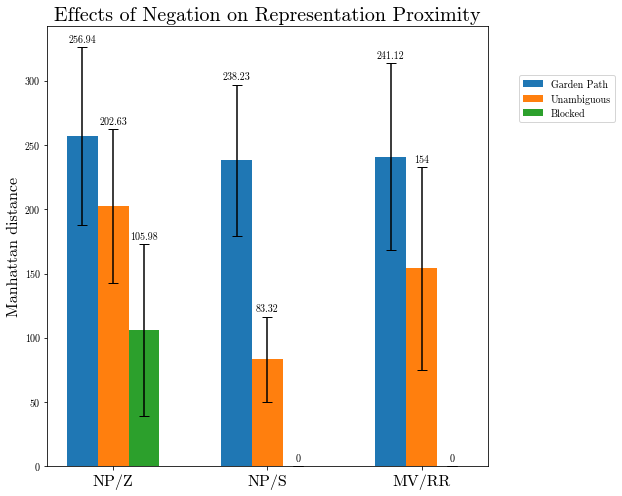

In [99]:
labels = ['NP/Z', 'NP/S', 'MV/RR']
font = {'fontname':'Times New Roman'}

x = np.arange(len(labels))
width = 0.2
sigfigs = 2
gp_means = round_list([256.93564, 238.23181, 241.11772], sigfigs)
gp_stds = [69.179276, 58.854836, 72.91912]
un_means = round_list([202.6271, 83.31759, 153.99513], sigfigs)
un_stds = [59.56708, 33.173855, 79.18737]
blk_means = round_list([105.98065, 0, 0], sigfigs)
blk_stds = [67.071976, 0, 0]
types = ['Garden Path', 'Unambiguous', 'Blocked']
cmap = ['blue', 'orange', 'green']


fig, ax = plt.subplots()
rects1 = ax.bar(x - width, gp_means, width, yerr=gp_stds, capsize=5, label='Garden Path')
rects2 = ax.bar(x, un_means, width, yerr=un_stds, capsize=5, label='Unambiguous')
rects3 = ax.bar(x + width, blk_means, width, yerr=blk_stds, capsize=5, label='Blocked')

ax.set_ylabel('Manhattan distance', fontsize=16)
ax.set_title('Effects of Negation on Representation Proximity', fontsize=20)
ax.set_xticks(x, labels, fontsize=16)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

ax.legend(# How to specify the location of the legend. Think of the first two bb_to_anchor args as x, y coordinates of the lagend. 
         bbox_to_anchor=(0.3, 1.1, 1, -0.2), loc='upper right',
                   fontsize=10)
    

fig.set_size_inches(9, 7)

fig.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

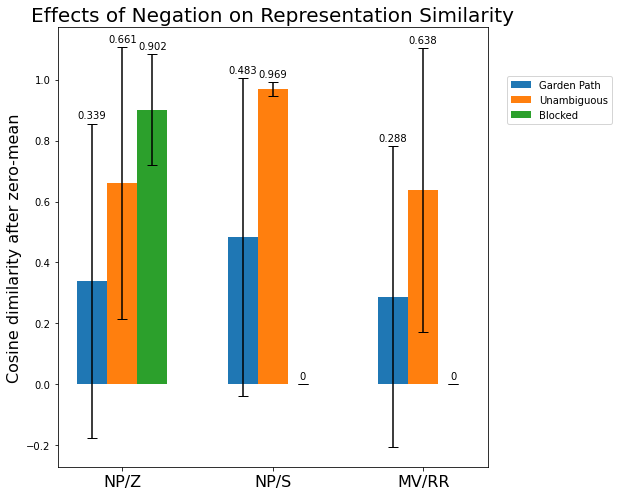

In [414]:
labels = ['NP/Z', 'NP/S', 'MV/RR']
x = np.arange(len(labels))
width = 0.2
sigfigs = 3
gp_means = round_list([0.3388951, 0.48257983, 0.2875767], sigfigs)
gp_stds = [0.51675373, 0.5215426, 0.4931778]
un_means = round_list([0.66127753, 0.96907324, 0.63803345], sigfigs)
un_stds = [0.44505143, 0.024080446, 0.46583387]
blk_means = round_list([0.90228856, 0, 0], sigfigs)
blk_stds = [0.18320338, 0, 0]
types = ['Garden Path', 'Unambiguous', 'Blocked']

plt.figure(facecolor='white', alpha=1)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, gp_means, width, yerr=gp_stds, capsize=5, label='Garden Path')
rects2 = ax.bar(x, un_means, width, yerr=un_stds, capsize=5, label='Unambiguous')
rects3 = ax.bar(x + width, blk_means, width, yerr=blk_stds, capsize=5, label='Blocked')

ax.set_ylabel('Cosine dimilarity after zero-mean', fontsize=16)
ax.set_title('Effects of Negation on Representation Similarity', fontsize=20)
ax.set_xticks(x, labels, fontsize=16)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)


# ax.set_ylim([-1,1])
ax.legend(# How to specify the location of the legend. Think of the first two bb_to_anchor args as x, y coordinates of the lagend. 
         bbox_to_anchor=(0.3, 1.1, 1, -0.2), loc='upper right',
                   fontsize=10)

fig.set_size_inches(9, 7)

fig.tight_layout()
plt.show()


/var/folders/ty/k9qdsxv117q7t3l77mk8gy8w0000gn/T/ipykernel_53496/2247368394.py:23: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots()


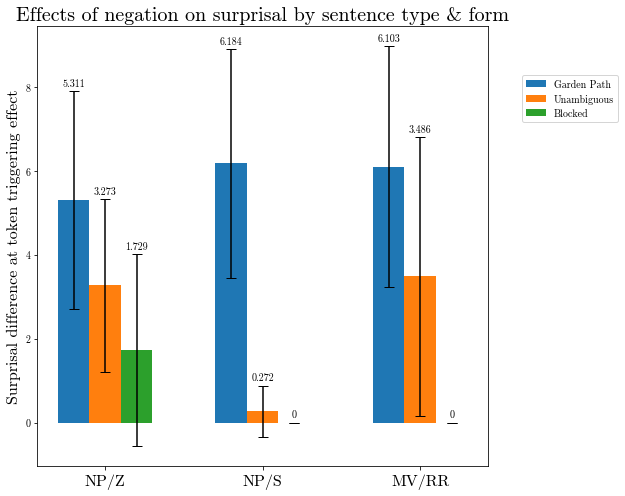

In [50]:
labels = ['NP/Z', 'NP/S', 'MV/RR']
x = np.arange(len(labels))
width = 0.2
sigfigs = 3

gp_means = round_list([0.028847428, -0.36081097, -0.26850247], sigfigs)
gp_stds = [0.7956172, 0.5916963, 1.2139946]
un_means = round_list([-0.17885284, -0.027269289, -0.094103985], sigfigs)
un_stds = [0.6459286, 0.30224448, 0.8400861]
blk_means = round_list([-0.26870304, 0, 0], sigfigs)
blk_stds = [0.5992434, 0, 0]


gp_means = round_list([5.310575323755398, 6.184373419931068, 6.103419670653651], sigfigs)
gp_stds = [2.5913303561256797, 2.7242792232336774, 2.8673922117147543]
un_means = round_list([3.273091097564901, 0.27221958892017034, 3.4856423942599193], sigfigs)
un_stds = [2.0647466889343042, 0.6138498374147356, 3.3159764199692874]
blk_means = round_list([1.7292871142681883, 0, 0], sigfigs)
blk_stds = [2.2926893198521543, 0, 0]

types = ['Garden Path', 'Unambiguous', 'Blocked']

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, gp_means, width, yerr=gp_stds, capsize=5, label='Garden Path')
rects2 = ax.bar(x, un_means, width, yerr=un_stds, capsize=5, label='Unambiguous')
rects3 = ax.bar(x + width, blk_means, width, yerr=blk_stds, capsize=5, label='Blocked')

ax.set_ylabel('Surprisal difference at token triggering effect', fontsize=16)
ax.set_title('Effects of negation on surprisal by sentence type & form', fontsize=20)
ax.set_xticks(x, labels, fontsize=16)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)


# ax.set_ylim([-1,1])

# ax.set_ylim([-1,1])
ax.legend(# How to specify the location of the legend. Think of the first two bb_to_anchor args as x, y coordinates of the lagend. 
         bbox_to_anchor=(0.3, 1.1, 1, -0.2), loc='upper right',
                   fontsize=10)

fig.set_size_inches(9, 7)

fig.tight_layout()
plt.show()


# Code to Produce Figures in Paper

/var/folders/ty/k9qdsxv117q7t3l77mk8gy8w0000gn/T/ipykernel_53496/2698528873.py:56: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12,4))


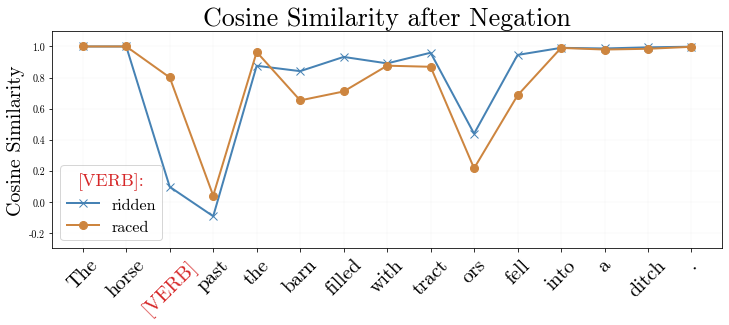

/var/folders/ty/k9qdsxv117q7t3l77mk8gy8w0000gn/T/ipykernel_53496/2698528873.py:106: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12,4))


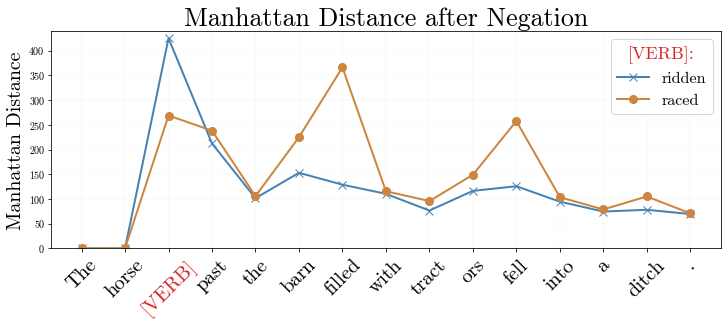

/var/folders/ty/k9qdsxv117q7t3l77mk8gy8w0000gn/T/ipykernel_53496/2698528873.py:156: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(12,4))


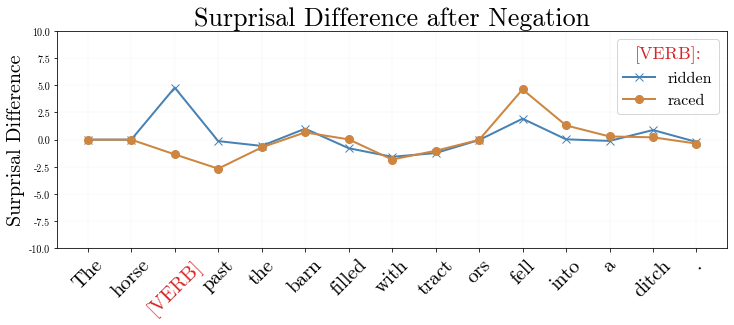

In [96]:
###### Cosine/Manhattan/Suprisal for TWO Sentences ###### 

# Made trigger word(s) [VERB]
# made lines a little thicker
# Added markers
# Made font WAY bigger. 
# added very faint grid lines. 
# Added a legend with [VERB] as title and substituded words different colors. 
sentence = 'The captive taken into the dark cave lit by torches tried to escape but failed.'
# ADDED THIS TO EXPERIMENT WITH CHANGING THE VERB
sentence1 = 'The captive walked into the dark cave lit by torches tried to escape but failed.'
_sentence = 'The captive who was taken into the dark cave lit by torches tried to escape but failed.'
_sentence1 = 'The captive who was walked into the dark cave lit by torches tried to escape but failed.'
postfix = ' tried to escape but failed.'
verb_idx = 2
verbs = ["taken", "walked"]

sentence = 'The lawyer given the report littered with profanity grumbled about her workload.'
# ADDED THIS TO EXPERIMENT WITH CHANGING THE VERB
sentence1 = 'The lawyer handed the report littered with profanity grumbled about her workload.'
_sentence = 'The lawyer who was given the report littered with profanity grumbled about her workload.'
_sentence1 = 'The lawyer who was handed the report littered with profanity grumbled about her workload.'

postfix = ' dropped it on the ground.'
verb_idx = 2
verbs = ["given", "handed"]


sentence = 'The horse ridden past the barn filled with tractors fell into a ditch.'
sentence1 = 'The horse raced past the barn filled with tractors fell into a ditch.'
_sentence = 'The horse that was ridden past the barn filled with tractors fell into a ditch.'
_sentence1 = 'The horse that was raced past the barn filled with tractors fell into a ditch.'
postfix = ' fell into a ditch.'
verb_idx = 2
verbs = ["ridden", "raced"]




dists, sims, diffs, cutoffs = distance_track(sentence, _sentence, postfix, tokenizer, model)
dists1, sims1, diffs1, cutoffs1 = distance_track(sentence1, _sentence1, postfix, tokenizer, model)

surps, cutoffs = surprisal_track(sentence, _sentence, postfix, tokenizer, lmhmodel)
surps1, cutoffs1 = surprisal_track(sentence1, _sentence1, postfix, tokenizer, lmhmodel)

tokens = tokenizer.tokenize(sentence)
tokens = [token.strip('Ġ') for token in tokens]
n = 1
for i in range(len(tokens)):
    if tokens[i] in tokens[:i]:
        tokens[i] = " "*n + tokens[i] + " "*n

fig, ax = plt.subplots(figsize=(12,4))
y1=sims
y2 = sims1
x = list(range(len(y1)))


# Change the token index that triggers the GP to "VERB"
# Need to make sure the verbs we swap in here are tokenized to the same length. 
tokens[2] = "[VERB]"

#Just me changing values to make the plots more realistic
# y2[2] = 0.5
# y2[3] = 0.7
# y2[7] = 0.5
# y2[10] = 0.7

ax.plot(tokens, y1,color='steelblue', marker='x', markersize=8, linewidth=2)
ax.plot(tokens, y2, color='peru', marker='o', markersize=8, linewidth=2)

# Set ylim to be 0-1, but if we get negative scores, we should set to -1,1. 
ax.set_ylim(-0.3,1.1)
ax.set_ylabel("Cosine Similarity", fontsize=20)

ax.set_title("Cosine Similarity after Negation", fontsize=26)

# Makes very faint grid lines. 
ax.grid(True,linewidth=0.06)

#This allows us to change rotation
plt.xticks(rotation = 45, c='black')

# Changing the GP trigger to a different color: 
xticks = ax.get_xticklabels()
# INDX OF TOKEN THAT TRIGGERS GARDEN PATH 
target_ticks = [2]

for i, lab in enumerate(xticks[1:-1]):
    if i+1 in target_ticks:
        lab.set_color('tab:red')
        
#plt.legend(["taken","walked"], bbox_to_anchor=(1.5, 1.0, -0.25, 0), loc='upper right', ncol=1, fontsize=20)
legend = ax.legend(verbs,  fontsize=16, title="[VERB]:", title_fontsize=18)
# This changes the  color of the legend title. 
plt.setp(legend.get_title(), color='tab:red')

        
plt.xticks(tokens, fontsize=20)
plt.show()

###Manhattan Distances
fig, ax = plt.subplots(figsize=(12,4))
y1=dists
y2 = dists1
x = list(range(len(y1)))
# Change the token index that triggers the GP to "VERB"
# Need to make sure the verbs we swap in here are tokenized to the same length. 
tokens[2] = "[VERB]"


#Just me changing values to make the plots more realistic
# y2[2] = 0.5
# y2[3] = 0.7
# y2[7] = 0.5
# y2[10] = 0.7

ax.plot(tokens, y1,color='steelblue', marker='x', markersize=8, linewidth=2)
ax.plot(tokens, y2, color='peru', marker='o', markersize=8, linewidth=2)

# Set ylim to be 0-1, but if we get negative scores, we should set to -1,1. 
ax.set_ylim(0,440) #330
ax.set_ylabel("Manhattan Distance", fontsize=20)

ax.set_title("Manhattan Distance after Negation", fontsize=26)

# Makes very faint grid lines. 
ax.grid(True,linewidth=0.06)

#This allows us to change rotation
plt.xticks(rotation = 45, c='black')

# Changing the GP trigger to a different color: 
xticks = ax.get_xticklabels()
# INDX OF TOKEN THAT TRIGGERS GARDEN PATH 
target_ticks = [2]

for i, lab in enumerate(xticks[1:-1]):
    if i+1 in target_ticks:
        lab.set_color('tab:red')
        
#plt.legend(["taken","walked"], bbox_to_anchor=(1.5, 1.0, -0.25, 0), loc='upper right', ncol=1, fontsize=20)
legend = ax.legend(verbs,  fontsize=16, title="[VERB]:", title_fontsize=18)
# This changes the  color of the legend title. 
plt.setp(legend.get_title(), color='tab:red')

        
plt.xticks(tokens, fontsize=20)
plt.show()


###Manhattan Distances
fig, ax = plt.subplots(figsize=(12,4))
y1=surps
y2 = surps1
x = list(range(len(y1)))
# Change the token index that triggers the GP to "VERB"
# Need to make sure the verbs we swap in here are tokenized to the same length. 
tokens[2] = "[VERB]"

#Just me changing values to make the plots more realistic
# y2[2] = 0.5
# y2[3] = 0.7
# y2[7] = 0.5
# y2[10] = 0.7

ax.plot(tokens, y1,color='steelblue', marker='x', markersize=8, linewidth=2)
ax.plot(tokens, y2, color='peru', marker='o', markersize=8, linewidth=2)

# Set ylim to be 0-1, but if we get negative scores, we should set to -1,1. 
ax.set_ylim(-10, 10)
ax.set_ylabel("Surprisal Difference", fontsize=20)

ax.set_title("Surprisal Difference after Negation", fontsize=26)

# Makes very faint grid lines. 
ax.grid(True,linewidth=0.06)

#This allows us to change rotation
plt.xticks(rotation = 45, c='black')

# Changing the GP trigger to a different color: 
xticks = ax.get_xticklabels()
# INDX OF TOKEN THAT TRIGGERS GARDEN PATH 
target_ticks = [2]

for i, lab in enumerate(xticks[1:-1]):
    if i+1 in target_ticks:
        lab.set_color('tab:red')
        
#plt.legend(["taken","walked"], bbox_to_anchor=(1.5, 1.0, -0.25, 0), loc='upper right', ncol=1, fontsize=20)
legend = ax.legend(verbs,  fontsize=16, title="[VERB]:", title_fontsize=18)
# This changes the  color of the legend title. 
plt.setp(legend.get_title(), color='tab:red')

        
plt.xticks(tokens, fontsize=20)
plt.show()



/var/folders/ty/k9qdsxv117q7t3l77mk8gy8w0000gn/T/ipykernel_53496/2796492000.py:28: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,3))


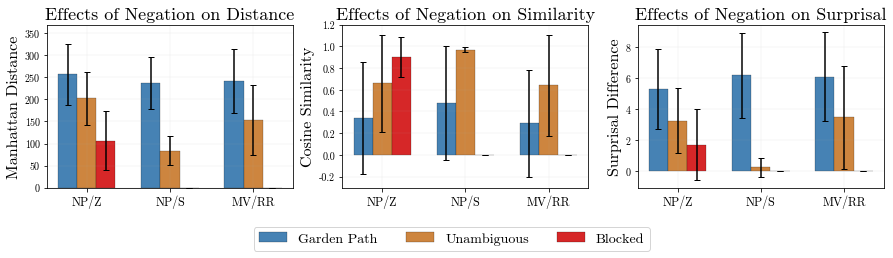

In [100]:
############ NEW  BAR CHARTS ########################

# Changed colors to match our theme
# Made this ONE figure with subplots 
# Removed numbers/labels on bar charts to make it easier to read. 
# Moved legend to bottom


def round_list(l, n):
    return [round(i, n) for i in l]

labels = ['NP/Z', 'NP/S', 'MV/RR']

x = np.arange(len(labels))
width = 0.23
sigfigs = 2
types = ['Garden Path', 'Unambiguous', 'Blocked']
cmap = ['steelblue', 'peru', 'tab:red']

#FIGURE 1
gp_dist_means = round_list([256.93564, 238.23181, 241.11772], sigfigs)
gp_dist_stds = [69.179276, 58.854836, 72.91912]
un_dist_means = round_list([202.6271, 83.31759, 153.99513], sigfigs)
un_dist_stds = [59.56708, 33.173855, 79.18737]
blk_dist_means = round_list([105.98065, 0, 0], sigfigs)
blk_dist_stds = [67.071976, 0, 0]

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,3))
rects1 = ax1.bar(x - width, gp_dist_means, width, yerr=gp_dist_stds, capsize=3, label='Garden Path', color="steelblue",edgecolor='black',linewidth=0.2)
rects2 = ax1.bar(x, un_dist_means, width, yerr=un_dist_stds, capsize=3, label='Unambiguous', color='peru', edgecolor='black',linewidth=0.2)
rects3 = ax1.bar(x + width, blk_dist_means, width, yerr=blk_dist_stds, capsize=3, label='Blocked',color='tab:red', edgecolor='black',linewidth=0.2)

ax1.set_ylim(0,370)

ax1.set_ylabel('Manhattan Distance', fontsize=16)
ax1.set_title('Effects of Negation on Distance', fontsize=18)
ax1.set_xticks(x, labels, fontsize=12)

ax1.grid(True,linewidth=0.1)

#FIGURE 2
gp_sim_means = round_list([0.3388951, 0.48257983, 0.2875767], sigfigs)
gp_sim_stds = [0.51675373, 0.5215426, 0.4931778]
un_sim_means = round_list([0.66127753, 0.96907324, 0.63803345], sigfigs)
un_sim_stds = [0.44505143, 0.024080446, 0.46583387]
blk_sim_means = round_list([0.90228856, 0, 0], sigfigs)
blk_sim_stds = [0.18320338, 0, 0]

ax2.set_ylim(-0.3,1.2)

rects1 = ax2.bar(x - width, gp_sim_means, width, yerr=gp_sim_stds, capsize=3, label='Garden Path', color="steelblue",edgecolor='black',linewidth=0.2)
rects2 = ax2.bar(x, un_sim_means, width, yerr=un_sim_stds, capsize=3, label='Unambiguous', color='peru', edgecolor='black',linewidth=0.2)
rects3 = ax2.bar(x + width, blk_sim_means, width, yerr=blk_sim_stds, capsize=3, label='Blocked',color='tab:red', edgecolor='black',linewidth=0.2)

ax2.set_ylabel('Cosine Similarity', fontsize=16)
ax2.set_title('Effects of Negation on Similarity', fontsize=18)
ax2.set_xticks(x, labels, fontsize=12)

ax2.grid(True,linewidth=0.1)

#FIGURE 3:
gp_sup_means = round_list([0.028847428, -0.36081097, -0.26850247], sigfigs)
gp_sup_stds = [0.7956172, 0.5916963, 1.2139946]
un_sup_means = round_list([-0.17885284, -0.027269289, -0.094103985], sigfigs)
un_sup_stds = [0.6459286, 0.30224448, 0.8400861]
blk_sup_means = round_list([-0.26870304, 0, 0], sigfigs)
blk_sup_stds = [0.5992434, 0, 0]

gp_sup_means = round_list([5.310575323755398, 6.184373419931068, 6.103419670653651], sigfigs)
gp_sup_stds = [2.5913303561256797, 2.7242792232336774, 2.8673922117147543]
un_sup_means = round_list([3.273091097564901, 0.27221958892017034, 3.4856423942599193], sigfigs)
un_sup_stds = [2.0647466889343042, 0.6138498374147356, 3.3159764199692874]
blk_sup_means = round_list([1.7292871142681883, 0, 0], sigfigs)
blk_sup_stds = [2.2926893198521543, 0, 0]

rects1 = ax3.bar(x - width, gp_sup_means, width, yerr=gp_sup_stds, capsize=3, label='Garden Path', color="steelblue",edgecolor='black',linewidth=0.2)
rects2 = ax3.bar(x, un_sup_means, width, yerr=un_sup_stds, capsize=3, label='Unambiguous', color='peru', edgecolor='black',linewidth=0.2)
rects3 = ax3.bar(x + width, blk_sup_means, width, yerr=blk_sup_stds, capsize=3, label='Blocked',color='tab:red', edgecolor='black',linewidth=0.2)

ax3.set_ylabel('Surprisal Difference', fontsize=16)
ax3.set_title('Effects of Negation on Surprisal', fontsize=18)
ax3.set_xticks(x, labels, fontsize=12)

ax3.grid(True,linewidth=0.1)


fig.legend(["Garden Path","Unambiguous","Blocked"],
         bbox_to_anchor=(0., -0.2, 1, -0.2), loc='lower center', ncol=3,fontsize=14)

plt.show()